In [1]:
!pip install --quiet langchain langchain_community chromadb langchain_openai langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.9/19.9 MB 66.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.3/103.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 71.2 MB/s eta 0:00:

In [8]:
import os
from google.colab import userdata
import bs4
from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain.prompts import ChatPromptTemplate
from langchain.load import loads, dumps
from operator import itemgetter

os.environ['LANGSMITH_API_KEY'] = userdata.get('LANG_TOKEN')
os.environ['LANGCHAIN_TRACING_V2'] = 'true'
os.environ['OPENAI_API_KEY'] = userdata.get('OAI_TOKEN')

In [5]:
loader = WebBaseLoader('https://en.wikipedia.org/wiki/Belgium')

docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
texts = text_splitter.split_documents(docs)

vectorstore = Chroma.from_documents(documents=texts, embedding=OpenAIEmbeddings())

retriever = vectorstore.as_retriever()

prompt = hub.pull('rlm/rag-prompt')

llm = ChatOpenAI(model_name='gpt-3.5-turbo', temperature=0)

In [ ]:
def format_docs(docs):
  return '\n\n'.join(doc.page_content for doc in docs)

chain = (
    {'context': retriever | format_docs, 'question': RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

chain.invoke("What is Belgium most famous for?")

# Multi-Query

In [11]:
template = """You are an AI language model assistant. Your task is to generate five
different versions of the given user question to retrieve relevant documents from a vector
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.
Provide these alternative questions separated by newlines. Original question: {question}"""

prompt_template = ChatPromptTemplate.from_template(template)

gen_queries = (
    prompt_template
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
    | (lambda x: x.split('\n'))
)

def get_unique_docs(docs):
  dump_docs = [dumps(doc) for sublist in docs for doc in sublist]
  unique_docs = list(set(dump_docs))
  return [loads(doc) for doc in unique_docs]

unique_docs = get_unique_docs(docs)

retrieval_chain = (
    gen_queries
    | retriever.map()
    | get_unique_docs
)

template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

chain = (
    {'context': retrieval_chain, 'question': RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

chain.invoke("What is Belgium most famous for?")

'Belgium is most famous for beer, chocolate, waffles, French fries, and its cuisine.'

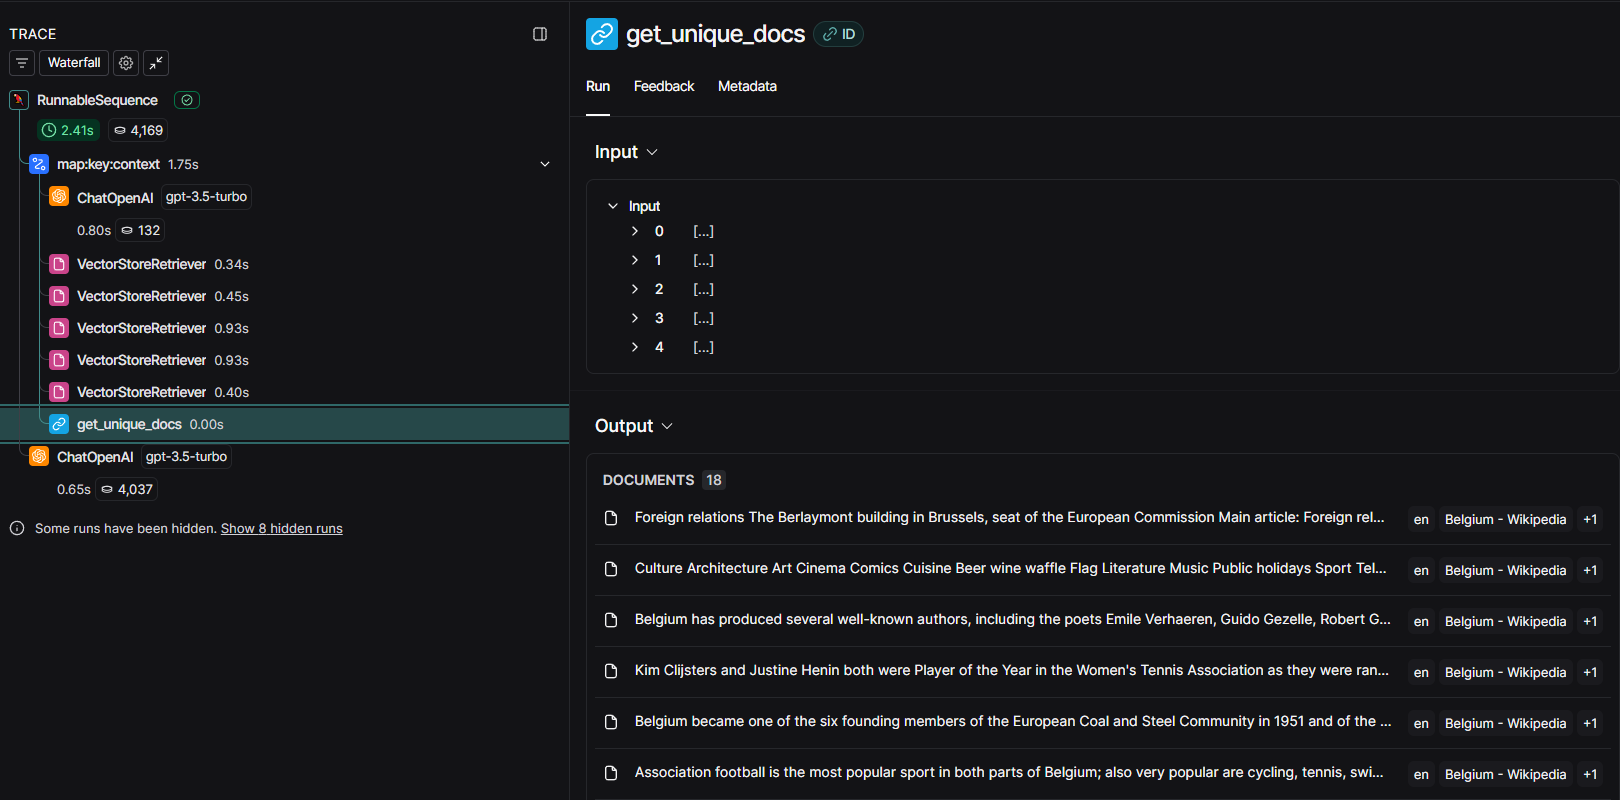

# RRF

In [10]:
template = """You are an AI language model assistant. Your task is to generate five
different versions of the given user question to retrieve relevant documents from a vector
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search.
Provide these alternative questions separated by newlines. Original question: {question}"""

prompt_template = ChatPromptTemplate.from_template(template)

gen_queries = (
    prompt_template
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
    | (lambda x: x.split('\n'))
)

def reciprocal_rank_fusion(results: list[list], k=60):
  fused_scores = {}

  for docs in results:
    for rank, doc in enumerate(docs):
      doc_str = dumps(doc)
      if doc_str not in fused_scores:
        fused_scores[doc_str] = 0
      previous_score = fused_scores[doc_str]
      fused_scores[doc_str] += 1 / (rank + k)

  reranked_results = [
      (loads(doc), score)
      for doc, score in sorted(fused_scores.items(), key=lambda x: x[1], reverse=True)
  ]

  return reranked_results

retrieve_chain = (
    gen_queries
    | retriever.map()
    | reciprocal_rank_fusion
)

template = """Answer the following question based on this context:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

chain = (
    {'context': retrieve_chain, 'question': RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

chain.invoke("Who governs Belgium?")

'Belgium is governed by a constitutional, popular monarchy and a federal parliamentary democracy. The country has a bicameral federal parliament composed of a Senate and a Chamber of Representatives.'

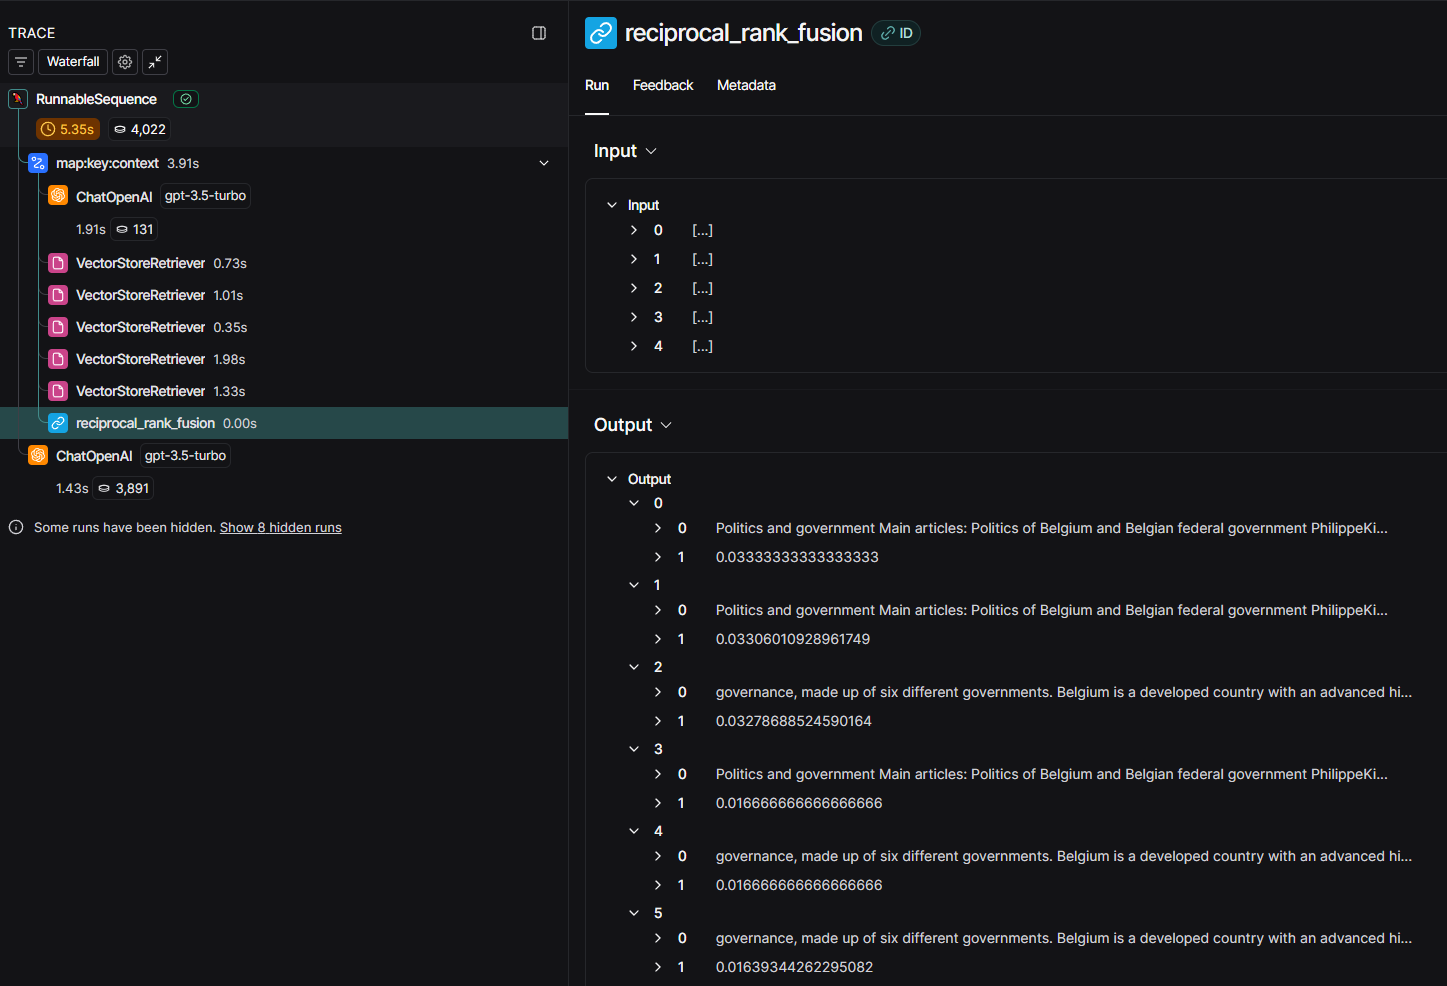

# Decomposition

In [15]:
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""

prompt_decomp = ChatPromptTemplate.from_template(template)

gen_queries_decomp = (
    prompt_decomp
    | llm
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)
question = "Is Belgium important?"
questions = gen_queries_decomp.invoke({"question": question})
questions

template = """Here is the question you need to answer:

\n --- \n {question} \n --- \n

Here is any available background question + answer pairs:

\n --- \n {qa_pairs} \n --- \n

Here is additional context relevant to the question:

\n --- \n {context} \n --- \n

Use the above context and any background question + answer pairs to answer the question: \n {question}
"""

prompt = ChatPromptTemplate.from_template(template)

def format_qa_pair(question, answer):
  formatted_str = ""
  formatted_str += f'Question: {question}\nAnswer: {answer}\n\n'
  return formatted_str.strip()

qa_pairs = ""
for q in questions:
  chain = (
      {'context': itemgetter('question') | retriever,
       'question': itemgetter('question'),
       'qa_pairs': itemgetter('qa_pairs')}
      | prompt
      | llm
      | StrOutputParser()
  )

  answer = chain.invoke({'question': q, 'qa_pairs': qa_pairs})
  qa_pair = format_qa_pair(q, answer)
  qa_pairs = qa_pairs + '\n --- \n' + qa_pair

answer

'Belgium holds cultural significance in Europe and the world due to its historical contributions to major artistic movements that have had a tremendous influence on European art and culture. Despite its political and linguistic divisions, Belgium has been a hub for flourishing cultural activities. However, cultural life in Belgium is now more concentrated within each language community, leading to a less pronounced shared cultural sphere. This rich cultural heritage has made Belgium an important player in shaping European art and culture.'

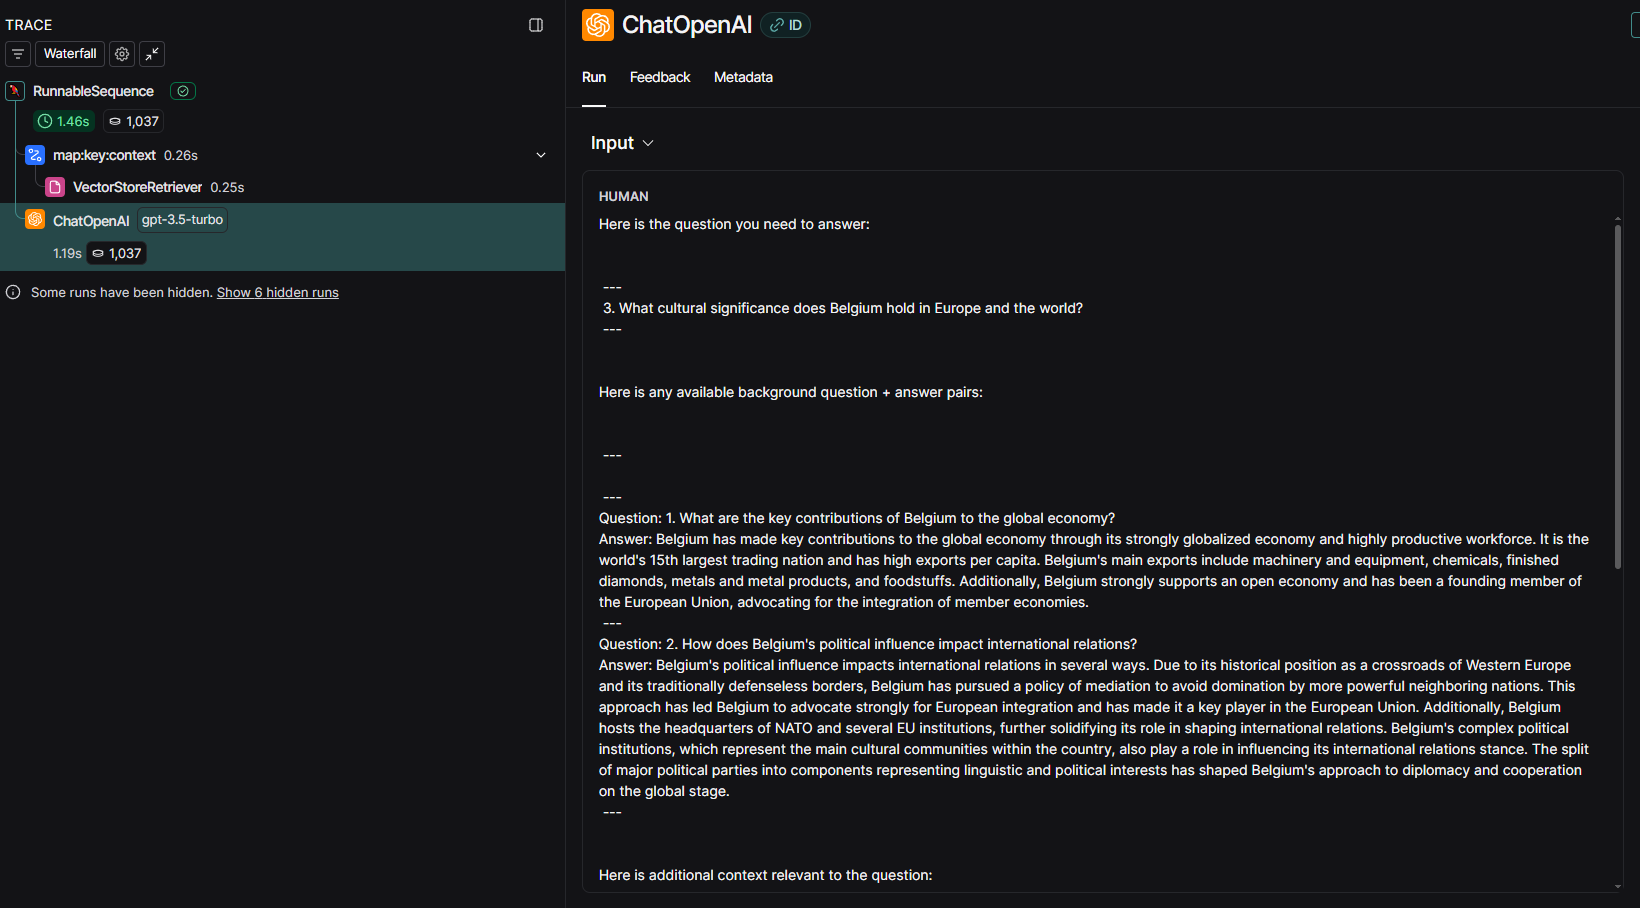

In [16]:
prompt = hub.pull('rlm/rag-prompt')

def retrieve_and_rag(q, prompt_rag, sub_q_chain):
  sub_questions = sub_q_chain.invoke({'question': q})

  rag_results = []

  for sub_q in sub_questions:
    relevant_docs = retriever.invoke(sub_q)
    chain = (
        prompt
        | llm
        | StrOutputParser()
    )

    answer = chain.invoke({'context': relevant_docs, 'question': sub_q})
    rag_results.append(answer)

  return rag_results, sub_questions

question = "Is Belgium important?"
answers, questions = retrieve_and_rag(question, prompt, gen_queries_decomp)

def format_qa_pairs(questions, answers):
  formatted_str = ""
  for i, (q, a) in enumerate(zip(questions, answers), start=1):
    formatted_str += f'QA pair {i}: Question: {q}, Answer: {a}\n\n'
  return formatted_str

context = format_qa_pairs(questions, answers)

template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

chain = (
    prompt
    | llm
    | StrOutputParser()
)

chain.invoke({'context': context, 'question': question})

"Yes, Belgium is important for several reasons. Its key contributions to the global economy, strong political influence in international relations, and significant role in cultural diversity and heritage preservation all highlight the country's importance on the global stage. Belgium's position as a major trading nation, advocate for European integration, and rich artistic heritage demonstrate its significance in various aspects of global affairs. Additionally, Belgium's historical policy of mediation and its location at the crossroads of Western Europe further emphasize its importance in shaping international relations. Overall, Belgium's contributions to the economy, politics, and culture make it an important player in the global community."

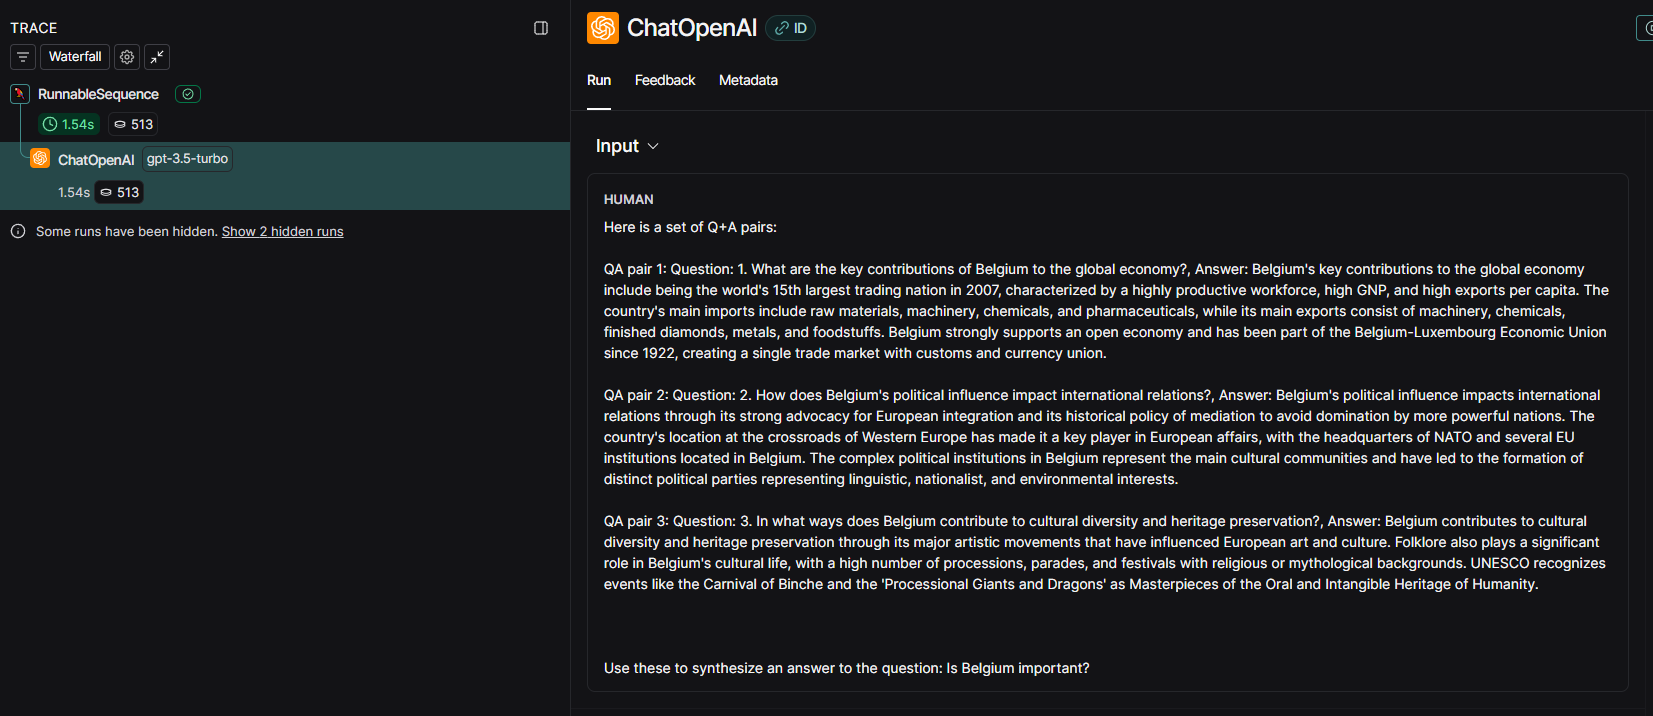